In [1]:
import os
import re
import glob



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score

from scipy.signal import welch
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from scipy.signal import welch
from scipy.stats import entropy
from scipy.stats import trim_mean, kurtosis
from scipy.stats import iqr

from scipy.stats import trim_mean, kurtosis
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, matthews_corrcoef, cohen_kappa_score


In [2]:

# Load the dataset
combined_df = pd.read_csv('C:/Users/DELL G7/Pictures/Camera Roll/projects/newdepression/combined_data.csv')

In [3]:
std_data = combined_df.copy()

In [4]:
# Standardize the 'activity' column
mean_activity = std_data['activity'].mean()
std_activity = std_data['activity'].std()
std_data['activity_standardized'] = (std_data['activity'] - mean_activity) / std_activity


In [5]:
std_data = std_data.drop('activity', axis=1)
std_data.head()

,timestamp,status,person,activity_standardized
0,2003-03-18 15:00:00,nondepressed,control_1,-0.332381
1,2003-03-18 15:01:00,nondepressed,control_1,-0.499176
2,2003-03-18 15:02:00,nondepressed,control_1,0.234721
3,2003-03-18 15:03:00,nondepressed,control_1,1.341127
4,2003-03-18 15:04:00,nondepressed,control_1,0.315339


In [6]:
# Convert the 'timestamp' column to datetime format
std_data['timestamp'] = pd.to_datetime(std_data['timestamp'])

# Round the 'timestamp' column to the nearest hour
std_data['hourly_timestamp'] = std_data['timestamp'].dt.floor('H')

# Group by 'person' and 'hourly_timestamp' and aggregate activity data
hourly_data = std_data.groupby(['person', 'hourly_timestamp', 'status'])['activity_standardized'].agg(
    ['sum', 'mean', 'std', 'skew', 'min', 'max']
).reset_index()

hourly_data.head()


,person,hourly_timestamp,status,sum,mean,std,skew,min,max
0,condition_1,2003-05-07 12:00:00,depressed,27.852200,0.464203,0.722576,1.046916,-0.499176,2.895099
1,condition_1,2003-05-07 13:00:00,depressed,17.513699,0.291895,0.649448,0.965757,-0.499176,2.136183
2,condition_1,2003-05-07 14:00:00,depressed,16.615786,0.276930,0.756995,1.231372,-0.499176,2.686606
3,condition_1,2003-05-07 15:00:00,depressed,6.541377,0.109023,0.829422,2.672737,-0.499176,3.865289
4,condition_1,2003-05-07 16:00:00,depressed,9.838355,0.163973,0.747972,1.665956,-0.499176,2.786683


In [7]:
def extract_frequency_features_adjusted(values, fs=32):
    # Compute the power spectral density using Welch's method with adjusted nperseg
    frequencies, psd_values = welch(values, fs=fs, nperseg=min(60, len(values)))
    
    fundamental_frequency = frequencies[np.argmax(psd_values)]
    
    # Define the frequency bands
    low_band = [0, 0.1]
    mid_band = [0.1, 0.5]
    high_band = [0.5, fs/2]  # Nyquist frequency
    
    low_band_power = np.sum(psd_values[(frequencies >= low_band[0]) & (frequencies < low_band[1])])
    mid_band_power = np.sum(psd_values[(frequencies >= mid_band[0]) & (frequencies < mid_band[1])])
    high_band_power = np.sum(psd_values[(frequencies >= high_band[0]) & (frequencies <= high_band[1])])
    

    peak_frequency = frequencies[np.argmax(psd_values)]
    
    return pd.Series({
        'Fundamental Frequency': fundamental_frequency,
        'Low Band Power': low_band_power,
        'Mid Band Power': mid_band_power,
        'High Band Power': high_band_power,
        'Peak Frequency': peak_frequency
    })

# # Extract frequency-domain features with adjusted nperseg
# frequency_features_adjusted = data.groupby(['person', 'hourly_timestamp']).apply(lambda x: extract_frequency_features_adjusted(x['activity'])).reset_index()


In [8]:
# Extract frequency-domain features with adjusted nperseg
frequency_features = std_data.groupby(['person', 'hourly_timestamp']).apply(lambda x: extract_frequency_features_adjusted(x['activity_standardized'])).reset_index()


# Merge the time-domain and adjusted frequency-domain features
merged_features = pd.merge(hourly_data, frequency_features, on=['person', 'hourly_timestamp'])

merged_features.head()

,person,hourly_timestamp,status,sum,mean,std,skew,min,max,Fundamental Frequency,Low Band Power,Mid Band Power,High Band Power,Peak Frequency
0,condition_1,2003-05-07 12:00:00,depressed,27.852200,0.464203,0.722576,1.046916,-0.499176,2.895099,2.666667,0.007132,0.0,1.054531,2.666667
1,condition_1,2003-05-07 13:00:00,depressed,17.513699,0.291895,0.649448,0.965757,-0.499176,2.136183,0.533333,0.000085,0.0,0.523059,0.533333
2,condition_1,2003-05-07 14:00:00,depressed,16.615786,0.276930,0.756995,1.231372,-0.499176,2.686606,5.333333,0.005905,0.0,1.307553,5.333333
3,condition_1,2003-05-07 15:00:00,depressed,6.541377,0.109023,0.829422,2.672737,-0.499176,3.865289,0.533333,0.022422,0.0,1.274211,0.533333
4,condition_1,2003-05-07 16:00:00,depressed,9.838355,0.163973,0.747972,1.665956,-0.499176,2.786683,1.600000,0.008082,0.0,0.565398,1.600000


In [9]:
# Extract all observations for persons with identifier starting with "condition"
condition_data = merged_features[merged_features['person'].str.startswith('condition')]


# Randomly sample 23 unique persons with the identifier starting with "control"
sampled_control_persons = merged_features[merged_features['person'].str.startswith('control')]['person'].unique()
sampled_control_persons = np.random.choice(sampled_control_persons, 23, replace=False)

# Extract all observations for these randomly sampled "control" persons
sampled_control_data = merged_features[merged_features['person'].isin(sampled_control_persons)]

# Concatenate the observations for "condition" and "control" persons
balanced_df = pd.concat([condition_data, sampled_control_data])


In [10]:
# 1) Number of observations (rows) per unique person
observations_per_person = balanced_df.groupby('person').size()

# 2) Total number of observations (rows) in each group
condition_group_size = condition_data.shape[0]
sampled_control_group_size = sampled_control_data.shape[0]

print(observations_per_person)
print("Total observations in condition group:", condition_group_size)
print("Total observations in sampled control group:", sampled_control_group_size)

person
condition_1     388
condition_10    360
condition_11    384
condition_12    370
condition_13    432
condition_14    362
condition_15    364
condition_16    698
condition_17    360
condition_18    357
condition_19    355
condition_2     649
condition_20    432
condition_21    343
condition_22    364
condition_23    525
condition_3     361
condition_4     361
condition_5     359
condition_6     358
condition_7     370
condition_8     322
condition_9     340
control_1       861
control_10      361
control_11      413
control_12      578
control_13      371
control_14      371
control_15      372
control_17      482
control_18      411
control_19      461
control_21      533
control_23      362
control_24      364
control_25      364
control_26      557
control_27      342
control_28      409
control_31      857
control_32      861
control_4       525
control_6       860
control_8       482
control_9       484
dtype: int64
Total observations in condition group: 9214
Total observatio

In [11]:
# Set the target observation count
target_count = 484

# Trim data for individuals with observations above the target count
trimmed_data_list = []
for person, count in observations_per_person.items():
    person_data = balanced_df[balanced_df['person'] == person]
    if count > target_count:
        person_data = person_data.sample(n=target_count, random_state=42)
    trimmed_data_list.append(person_data)

trimmed_df = pd.concat(trimmed_data_list)
trimmed_df

,person,hourly_timestamp,status,sum,mean,std,skew,min,max,Fundamental Frequency,Low Band Power,Mid Band Power,High Band Power,Peak Frequency
0,condition_1,2003-05-07 12:00:00,depressed,27.852200,0.464203,0.722576,1.046916,-0.499176,2.895099,2.666667,7.131876e-03,0.0,1.054531e+00,2.666667
1,condition_1,2003-05-07 13:00:00,depressed,17.513699,0.291895,0.649448,0.965757,-0.499176,2.136183,0.533333,8.480843e-05,0.0,5.230594e-01,0.533333
2,condition_1,2003-05-07 14:00:00,depressed,16.615786,0.276930,0.756995,1.231372,-0.499176,2.686606,5.333333,5.904554e-03,0.0,1.307553e+00,5.333333
3,condition_1,2003-05-07 15:00:00,depressed,6.541377,0.109023,0.829422,2.672737,-0.499176,3.865289,0.533333,2.242186e-02,0.0,1.274211e+00,0.533333
4,condition_1,2003-05-07 16:00:00,depressed,9.838355,0.163973,0.747972,1.665956,-0.499176,2.786683,1.600000,8.081863e-03,0.0,5.653981e-01,1.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26225,control_9,2003-12-01 08:00:00,nondepressed,-19.689895,-0.328165,0.523348,4.056770,-0.479717,2.586529,0.000000,2.438294e-02,0.0,2.089081e-02,0.000000
26226,control_9,2003-12-01 09:00:00,nondepressed,-7.580588,-0.126343,0.660453,2.574614,-0.474157,2.492012,1.600000,2.119243e-04,0.0,8.545981e-01,1.600000
26227,control_9,2003-12-01 10:00:00,nondepressed,-21.127110,-0.352119,0.302636,2.564643,-0.485276,0.754565,3.733333,5.063093e-03,0.0,2.432506e-01,3.733333
26228,control_9,2003-12-01 11:00:00,nondepressed,-29.116584,-0.485276,0.000000,0.000000,-0.485276,-0.485276,0.000000,3.851860e-33,0.0,1.925930e-33,0.000000


In [12]:
# Bootstrap data for individuals with observations below the target count
bootstrapped_data_list = []
for person, count in observations_per_person.items():
    person_data = trimmed_df[trimmed_df['person'] == person]
    if count < target_count:
        bootstrap_sample = person_data.sample(n=target_count - count, replace=True, random_state=42)
        person_data = pd.concat([person_data, bootstrap_sample])
    bootstrapped_data_list.append(person_data)

balanced_trimmed_df = pd.concat(bootstrapped_data_list)
balanced_trimmed_df

,person,hourly_timestamp,status,sum,mean,std,skew,min,max,Fundamental Frequency,Low Band Power,Mid Band Power,High Band Power,Peak Frequency
0,condition_1,2003-05-07 12:00:00,depressed,27.852200,0.464203,0.722576,1.046916,-0.499176,2.895099,2.666667,7.131876e-03,0.0,1.054531e+00,2.666667
1,condition_1,2003-05-07 13:00:00,depressed,17.513699,0.291895,0.649448,0.965757,-0.499176,2.136183,0.533333,8.480843e-05,0.0,5.230594e-01,0.533333
2,condition_1,2003-05-07 14:00:00,depressed,16.615786,0.276930,0.756995,1.231372,-0.499176,2.686606,5.333333,5.904554e-03,0.0,1.307553e+00,5.333333
3,condition_1,2003-05-07 15:00:00,depressed,6.541377,0.109023,0.829422,2.672737,-0.499176,3.865289,0.533333,2.242186e-02,0.0,1.274211e+00,0.533333
4,condition_1,2003-05-07 16:00:00,depressed,9.838355,0.163973,0.747972,1.665956,-0.499176,2.786683,1.600000,8.081863e-03,0.0,5.653981e-01,1.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26225,control_9,2003-12-01 08:00:00,nondepressed,-19.689895,-0.328165,0.523348,4.056770,-0.479717,2.586529,0.000000,2.438294e-02,0.0,2.089081e-02,0.000000
26226,control_9,2003-12-01 09:00:00,nondepressed,-7.580588,-0.126343,0.660453,2.574614,-0.474157,2.492012,1.600000,2.119243e-04,0.0,8.545981e-01,1.600000
26227,control_9,2003-12-01 10:00:00,nondepressed,-21.127110,-0.352119,0.302636,2.564643,-0.485276,0.754565,3.733333,5.063093e-03,0.0,2.432506e-01,3.733333
26228,control_9,2003-12-01 11:00:00,nondepressed,-29.116584,-0.485276,0.000000,0.000000,-0.485276,-0.485276,0.000000,3.851860e-33,0.0,1.925930e-33,0.000000


In [13]:
# Distribution of data for each unique person
distribution_per_person = balanced_trimmed_df.groupby('person').size()

# Total number of observations in each group
condition_group_count = balanced_trimmed_df[balanced_trimmed_df['person'].str.startswith('condition')].shape[0]
control_group_count = balanced_trimmed_df[balanced_trimmed_df['person'].str.startswith('control')].shape[0]

distribution_per_person


person
condition_1     484
condition_10    484
condition_11    484
condition_12    484
condition_13    484
condition_14    484
condition_15    484
condition_16    484
condition_17    484
condition_18    484
condition_19    484
condition_2     484
condition_20    484
condition_21    484
condition_22    484
condition_23    484
condition_3     484
condition_4     484
condition_5     484
condition_6     484
condition_7     484
condition_8     484
condition_9     484
control_1       484
control_10      484
control_11      484
control_12      484
control_13      484
control_14      484
control_15      484
control_17      484
control_18      484
control_19      484
control_21      484
control_23      484
control_24      484
control_25      484
control_26      484
control_27      484
control_28      484
control_31      484
control_32      484
control_4       484
control_6       484
control_8       484
control_9       484
dtype: int64

In [14]:
# Split the data into features and target
tX_data = balanced_trimmed_df.drop(columns=['person','hourly_timestamp', 'status', ])
ty_data = balanced_trimmed_df['status']


# Replace infinite values with NaN
tX_data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaN values with the median of the respective columns
tX_data = tX_data.fillna(tX_data.median())

RANDOM FOREST

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)


In [18]:

rf.fit(tX_data, ty_data)

# Extract feature importances
feature_importances = rf.feature_importances_

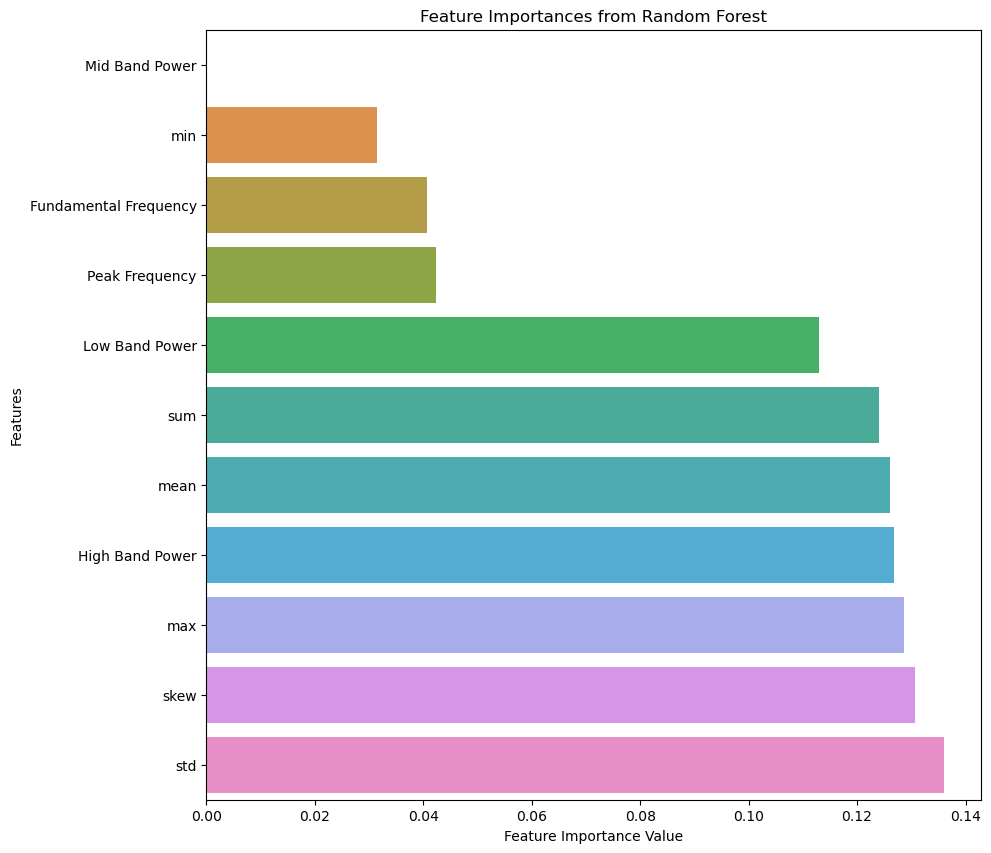

In [19]:
# Sort features based on importance
sorted_idx = feature_importances.argsort()

# Plot
plt.figure(figsize=(10, 10))
plt.title('Feature Importances from Random Forest')
sns.barplot(x=feature_importances[sorted_idx], y=tX_data.columns[sorted_idx])
plt.xlabel('Feature Importance Value')
plt.ylabel('Features')
plt.show()

In [20]:
# Select important features based on a threshold
threshold = 0.10
important_features = tX_data.columns[feature_importances > threshold]
important_features

Index(['sum', 'mean', 'std', 'skew', 'max', 'Low Band Power',
       'High Band Power'],
      dtype='object')

In [23]:
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter grid
param_dist = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Use RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                                   n_iter=100, cv=3, verbose=1, random_state=42, n_jobs=1)
random_search.fit(tX_data[important_features], ty_data)

# Get the best parameters
best_params = random_search.best_params_

best_params


Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 50,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}

In [24]:
random_search.fit(tX_data[important_features], ty_data)

# Get the best parameters
best_params = random_search.best_params_

best_params

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 50,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}

In [25]:
# Lists to store evaluation metrics
tnew_accuracies = []
tnew_classification_reports = []
tnew_mcc_scores = []
tnew_kappa_scores = []
tnew_confusion_matrices = []

# Initialize the Random Forest Classifier with the best parameters
rf_best = RandomForestClassifier(**best_params, random_state=42)

# Extract unique persons
persons = balanced_trimmed_df['person'].unique()

# Dictionary to store predictions for each person
tnew_predictions_dict = {}

In [26]:
# Create a list to store X_test data for each individual
combined_X_test_list = []


# LOOCV based on persons
for person in persons:
    # Split the data into train and test based on the current person in the loop
    X_train = tX_data[balanced_trimmed_df['person'] != person][important_features]
    y_train = balanced_trimmed_df[balanced_trimmed_df['person'] != person]['status']
    X_test = tX_data[balanced_trimmed_df['person'] == person][important_features]
    y_test = balanced_trimmed_df[balanced_trimmed_df['person'] == person]['status']
    
    # Inside your LOOCV loop, after defining X_test, add:
    combined_X_test_list.append(X_test)

    
    # Train the model using the best parameters
    rf_best.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = rf_best.predict(X_test)
    
    # Store predictions in the dictionary
    tnew_predictions_dict[person] = y_pred
    
    # Calculate evaluation metrics
    tnew_accuracies.append(accuracy_score(y_test, y_pred))
    tnew_classification_reports.append(classification_report(y_test, y_pred, output_dict=True))
    tnew_mcc_scores.append(matthews_corrcoef(y_test, y_pred))
    tnew_kappa_scores.append(cohen_kappa_score(y_test, y_pred))
    tnew_confusion_matrices.append(confusion_matrix(y_test, y_pred))

# Calculate average metrics
avg_accuracy = np.mean(tnew_accuracies)
avg_mcc = np.mean(tnew_mcc_scores)
avg_kappa = np.mean(tnew_kappa_scores)

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\Ap

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\Ap

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\Ap

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\Ap

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\Ap

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
# Create lists to store the results
tnewpersons_list = []
tnewcorrect_percentage_list = []
tnewincorrect_percentage_list = []

# Iterate over each person and calculate the percentages
for person, predictions in tnew_predictions_dict.items():
    # Get true labels for the person
    true_labels = balanced_trimmed_df[balanced_trimmed_df['person'] == person]['status'].values
    
    # Calculate the number of correct predictions
    tcorrect_predictions = np.sum(predictions == true_labels)
    
    # Calculate the percentage of correct and incorrect predictions
    total_predictions = len(predictions)
    correct_percentage = (tcorrect_predictions / total_predictions) * 100
    incorrect_percentage = 100 - correct_percentage
    
    # Append to the lists
    tnewpersons_list.append(person)
    tnewcorrect_percentage_list.append(correct_percentage)
    tnewincorrect_percentage_list.append(incorrect_percentage)

# Create a DataFrame from the results
percentage_df = pd.DataFrame({
    'Person': tnewpersons_list,
    'Correct Prediction (%)': tnewcorrect_percentage_list,
    'Incorrect Prediction (%)': tnewincorrect_percentage_list
})

# Display the DataFrame
percentage_df

,Person,Correct Prediction (%),Incorrect Prediction (%)
0,condition_1,65.495868,34.504132
1,condition_10,44.008264,55.991736
2,condition_11,72.520661,27.479339
3,condition_12,64.049587,35.950413
4,condition_13,45.247934,54.752066
5,condition_14,83.264463,16.735537
6,condition_15,78.512397,21.487603
7,condition_16,40.909091,59.090909
8,condition_17,92.148760,7.851240
9,condition_18,93.595041,6.404959


In [28]:
from sklearn.metrics import classification_report

# Lists to store true labels and predictions for each group
tcondition_true_labels = []
tcondition_predicted_labels = []
tcontrol_true_labels = []
tcontrol_predicted_labels = []

# Iterate over each person's predictions in the dictionary
for person, predictions in tnew_predictions_dict.items():
    # Get true labels for the person
    true_labels = balanced_trimmed_df[balanced_trimmed_df['person'] == person]['status'].values
    
    # Append true labels and predictions to the respective lists based on the person's group
    if person.startswith('condition'):
        tcondition_true_labels.extend(true_labels)
        tcondition_predicted_labels.extend(predictions)
    else:
        tcontrol_true_labels.extend(true_labels)
        tcontrol_predicted_labels.extend(predictions)

# Combine true labels and predicted labels from both groups
tcombined_true_labels = tcondition_true_labels + tcontrol_true_labels
tcombined_predicted_labels = tcondition_predicted_labels + tcontrol_predicted_labels

# Generate a single classification report for the combined data
combined_classification_report = classification_report(tcombined_true_labels, tcombined_predicted_labels, output_dict=True, zero_division=1)

# Convert the classification report to a DataFrame for better visualization
combined_report_df = pd.DataFrame(combined_classification_report).transpose()

# Display the combined classification report
combined_report_df


,precision,recall,f1-score,support
depressed,0.599983,0.643640,0.621045,11132.000000
nondepressed,0.615675,0.570877,0.592430,11132.000000
accuracy,0.607258,0.607258,0.607258,0.607258
macro avg,0.607829,0.607258,0.606738,22264.000000
weighted avg,0.607829,0.607258,0.606738,22264.000000


In [29]:
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score

# Calculate MCC and Cohen's Kappa for the combined data
combined_mcc = matthews_corrcoef(tcombined_true_labels, tcombined_predicted_labels)
combined_kappa = cohen_kappa_score(tcombined_true_labels, tcombined_predicted_labels)

combined_mcc, combined_kappa


(0.21508685119115842, 0.21451670858785488)

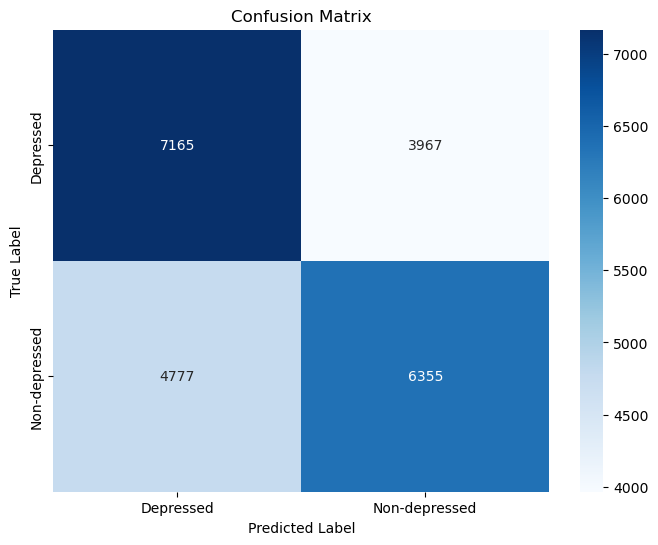

In [30]:
# Calculate the confusion matrix for the combined data
combined_cm = confusion_matrix(tcombined_true_labels, tcombined_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(combined_cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Depressed', 'Non-depressed'],
            yticklabels=['Depressed', 'Non-depressed'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



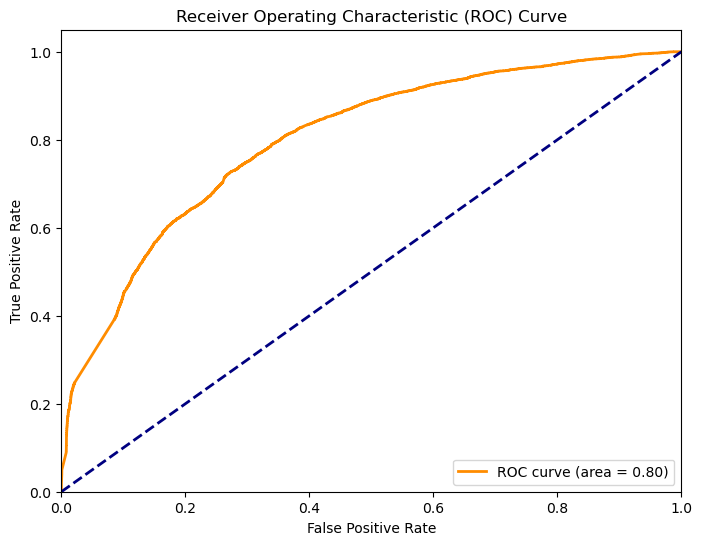

In [31]:
# For the ROC curve:

# After the loop, combine all X_test data
combined_X_test = pd.concat(combined_X_test_list)

# Compute the predicted probabilities using the Random Forest classifier
combined_predicted_probs = rf_best.predict_proba(combined_X_test)[:, 1]

# Compute ROC curve and ROC area for the combined data
fpr, tpr, _ = roc_curve(tcombined_true_labels, combined_predicted_probs, pos_label='nondepressed')
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

LOGISTIC REGRESSION

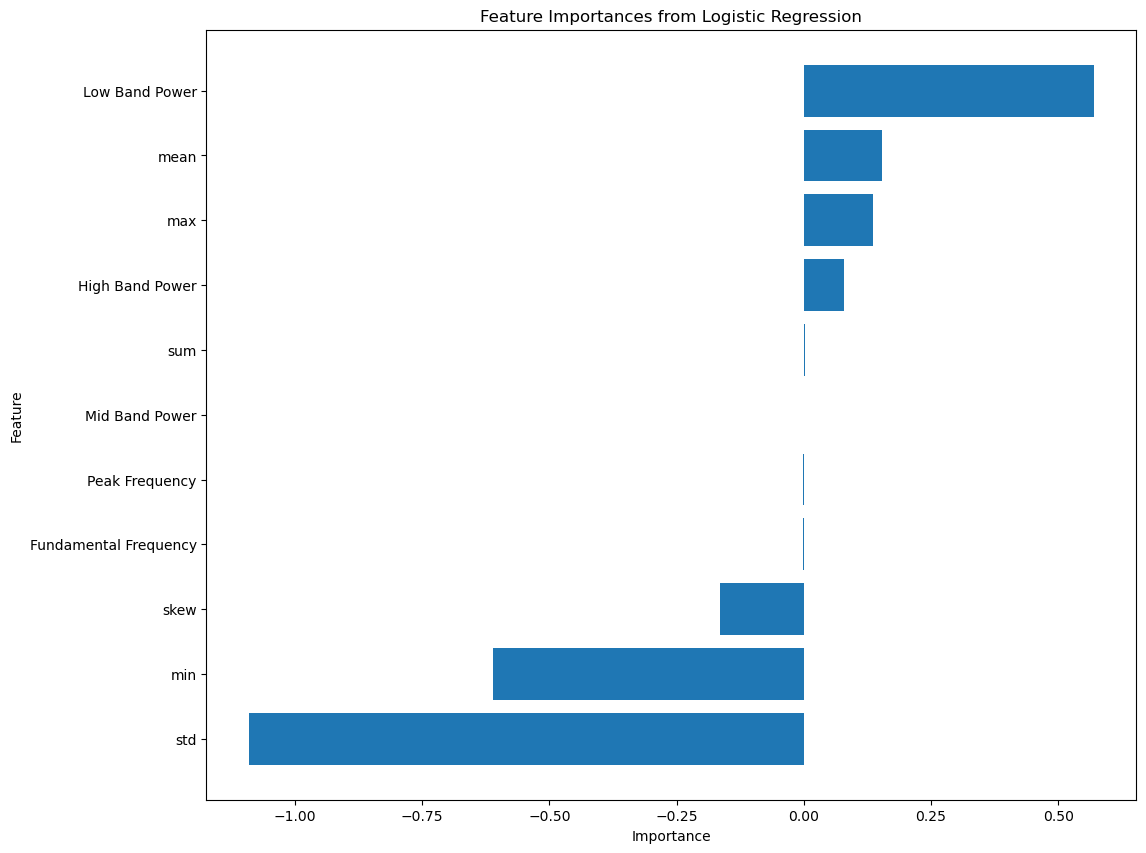

In [33]:
from sklearn.linear_model import LogisticRegression

# Initialize and fit the logistic regression model
logreg = LogisticRegression(max_iter=10000, random_state=42)
logreg.fit(tX_data, ty_data)

# Extract the coefficients
feature_importances = logreg.coef_[0]

# Create a DataFrame to visualize feature importances
importance_df = pd.DataFrame({
    'Feature': tX_data.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Logistic Regression')
plt.gca().invert_yaxis()  # To display the feature with the highest importance at the top
plt.show()

In [38]:
# Set a threshold
threshold = 0.07  # You can adjust this value based on your needs

# Select features where the importance (magnitude of coefficient) is above the threshold
selected_features = importance_df[importance_df['Importance'].abs() > threshold]['Feature'].tolist()

selected_features


['Low Band Power', 'mean', 'max', 'High Band Power', 'skew', 'min', 'std']

In [36]:
importance_df

,Feature,Importance
7,Low Band Power,0.570334
1,mean,0.153449
5,max,0.136773
9,High Band Power,0.079479
0,sum,0.002832
8,Mid Band Power,0.000000
10,Peak Frequency,-0.002191
6,Fundamental Frequency,-0.002191
3,skew,-0.164439
4,min,-0.610819


In [40]:


# Define the parameters to search
param_dist = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 1000, 5000]
}


# # Initialize Logistic Regression
# log_reg = LogisticRegression()

# Initialize RandomizedSearchCV
log_reg_random_search = RandomizedSearchCV(logreg, param_distributions=param_dist,
                                           n_iter=100, cv=10, verbose=2, random_state=42, n_jobs=1)


log_reg_random_search.fit(tX_data[important_features], ty_data)

# random_search.fit(tX_data[important_features], ty_data)


# Best parameters
best_params = log_reg_random_search.best_params_


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0006951927961775605, max_iter=100, penalty=l1, so

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.08858667904100823, max_iter=5000, penalty=l1, solver=saga; total time=  19.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=100, penalty=l1, solver=saga; total time=   0.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=100, penalty=l1, solver=saga; total time=   0.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=100, penalty=l1, solver=saga; total time=   0.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=100, penalty=l1, solver=saga; total time=   0.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=100, penalty=l1, solver=saga; total time=   0.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=100, penalty=l1, solver=saga; total time=   0.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=100, penalty=l1, solver=saga; total time=   0.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=100, penalty=l1, solver=saga; total time=   0.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=100, penalty=l1, solver=saga; total time=   0.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=100, penalty=l1, solver=saga; total time=   0.3s
[CV] END C=0.23357214690901212, max_iter=5000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.23357214690901212, max_iter=5000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.23357214690901212, max_iter=5000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.23357214690901212, max_iter=5000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.23357214690901212, max_iter=5000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.23357214690901212, max_iter=5000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.23357214690901212, max_iter=5000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.23357214690901212, max_iter=5000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.23357214690901212, max_iter=5000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.23357214690901212, max_iter=5000, p

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=1000, penalty=l1, solver=liblinear; total time=   4.2s
[CV] END C=78.47599703514607, max_iter=1000, penalty=l1, solver=liblinear; total time=   3.0s
[CV] END C=78.47599703514607, max_iter=1000, penalty=l1, solver=liblinear; total time=   4.0s
[CV] END C=78.47599703514607, max_iter=1000, penalty=l1, solver=liblinear; total time=   1.7s
[CV] END C=78.47599703514607, max_iter=1000, penalty=l1, solver=liblinear; total time=   3.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=1000, penalty=l1, solver=liblinear; total time=   3.3s
[CV] END C=78.47599703514607, max_iter=1000, penalty=l1, solver=liblinear; total time=   2.7s
[CV] END C=78.47599703514607, max_iter=1000, penalty=l1, solver=liblinear; total time=   2.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=1000, penalty=l1, solver=saga; total time=   3.1s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=1000, penalty=l1, solver=saga; total time=   3.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=1000, penalty=l1, solver=saga; total time=   3.1s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=1000, penalty=l1, solver=saga; total time=   3.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=1000, penalty=l1, solver=saga; total time=   3.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=1000, penalty=l1, solver=saga; total time=   3.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=1000, penalty=l1, solver=saga; total time=   3.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=1000, penalty=l1, solver=saga; total time=   3.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=1000, penalty=l1, solver=saga; total time=   3.1s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=1000, penalty=l1, solver=saga; total time=   3.1s
[CV] END C=0.08858667904100823, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.08858667904100823, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.08858667904100823, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.08858667904100823, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.08858667904100823, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.08858667904100823, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.08858667904100823, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.08858667904100823, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.08858667904100823, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.08858667904100823, max_iter=100, penalty=l2, solver

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=5000, penalty=l2, solver=saga; total time=  14.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=5000, penalty=l2, solver=saga; total time=  15.1s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=5000, penalty=l2, solver=saga; total time=  15.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=5000, penalty=l2, solver=saga; total time=  16.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=5000, penalty=l2, solver=saga; total time=  13.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=5000, penalty=l2, solver=saga; total time=  15.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=5000, penalty=l2, solver=saga; total time=  14.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=5000, penalty=l2, solver=saga; total time=  14.6s
[CV] END C=4.281332398719396, max_iter=5000, penalty=l2, solver=saga; total time=  11.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=5000, penalty=l2, solver=saga; total time=  14.3s
[CV] END C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=saga; total time=   1.4s
[CV] END C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=saga; total time=   1.4s
[CV] END C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=saga; total time=   1.3s
[CV] END C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=saga; total time=   1.4s
[CV] END C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=saga; total time=   1.3s
[CV] END C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=saga; total time=   1.5s
[CV] END C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=saga; total time=   1.6s
[CV] END C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=saga; total time=   1.3s
[CV] END C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=saga; total time=   0.9s
[CV] END C=0.0018329807108324356, max_iter=5000, penalty=l1, solver=saga; 

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=100, penalty=l1, solver=liblinear; total time=   0.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=100, penalty=l1, solver=liblinear; total time=   0.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=100, penalty=l1, solver=liblinear; total time=   0.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=100, penalty=l1, solver=liblinear; total time=   0.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=saga; total time=   3.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=saga; total time=   3.1s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=saga; total time=   3.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=saga; total time=   2.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=saga; total time=   2.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=saga; total time=   2.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=saga; total time=   2.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=saga; total time=   2.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=saga; total time=   2.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=saga; total time=   2.8s
[CV] END C=10000.0, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10000.0, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10000.0, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10000.0, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10000.0, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10000.0, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10000.0, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10000.0, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10000.0, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=10000.0, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=206.913808111479, max_iter=1000, penalty=l1, solver=saga; total time=   2.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=206.913808111479, max_iter=1000, penalty=l1, solver=saga; total time=   2.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=206.913808111479, max_iter=1000, penalty=l1, solver=saga; total time=   3.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=206.913808111479, max_iter=1000, penalty=l1, solver=saga; total time=   3.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=206.913808111479, max_iter=1000, penalty=l1, solver=saga; total time=   2.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=206.913808111479, max_iter=1000, penalty=l1, solver=saga; total time=   3.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=206.913808111479, max_iter=1000, penalty=l1, solver=saga; total time=   3.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=206.913808111479, max_iter=1000, penalty=l1, solver=saga; total time=   3.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=206.913808111479, max_iter=1000, penalty=l1, solver=saga; total time=   3.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=206.913808111479, max_iter=1000, penalty=l1, solver=saga; total time=   3.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.00026366508987303583, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.00026366508987303583, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.00026366508987303583, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.00026366508987303583, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.00026366508987303583, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.00026366508987303583, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.00026366508987303583, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.00026366508987303583, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.00026366508987303583, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.00026366508987303583, max_iter=100, penalty=l2, solver=saga; total time=   0.2s
[CV] END C=11.288378916846883, max_iter=5000, penalty=l1, solver=liblinear; total time=   1.5s
[CV] END C=11.288378916846883, max_iter=5000, penalty=l1, solver=liblinear; total time=   2.5s
[CV] END C=11.288378916846883, max_iter=5000, penalty=l1, solver=liblinear; total time=   3.4s
[CV] END C=11.288378916846883, max_iter=5000, penalty=l1, solver=liblinear; total time=   2.8s
[CV] END C=11.288378916846883, max_iter=5000, penalty=l1, solver=liblinear; total time=   1.7s
[CV] END C=11.288378916846883, max_iter=5000, penalty=l1, solver=liblinear; total time=   3.7s
[CV] END C=11.288378916846883, max_iter=5000, penalty=l1, solver=liblinear; total time=   2.9s
[CV] END C=11.288378916846883, max_iter=5000, penalty=l1, solver=liblinear; total time=   3.7s
[CV] END C=11.288378916846883, max_iter=5000, penalty=l1, solver=liblinear; total time=   3.1s
[CV] END C=11.288378916846883, max_iter=5000, penalt

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=1000, penalty=l1, solver=saga; total time=   3.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=1000, penalty=l1, solver=saga; total time=   3.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=1000, penalty=l1, solver=saga; total time=   3.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=1000, penalty=l1, solver=saga; total time=   3.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=1000, penalty=l1, solver=saga; total time=   3.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=1000, penalty=l1, solver=saga; total time=   3.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=1000, penalty=l1, solver=saga; total time=   3.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=1000, penalty=l1, solver=saga; total time=   4.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=1000, penalty=l1, solver=saga; total time=   3.7s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=1000, penalty=l1, solver=saga; total time=   3.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=1000, penalty=l2, solver=saga; total time=   2.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=1000, penalty=l2, solver=saga; total time=   2.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=1000, penalty=l2, solver=saga; total time=   3.1s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=1000, penalty=l2, solver=saga; total time=   2.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=1000, penalty=l2, solver=saga; total time=   2.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=1000, penalty=l2, solver=saga; total time=   2.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=1000, penalty=l2, solver=saga; total time=   2.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=1000, penalty=l2, solver=saga; total time=   2.7s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=1000, penalty=l2, solver=saga; total time=   2.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=1000, penalty=l2, solver=saga; total time=   2.6s
[CV] END C=0.00026366508987303583, max_iter=1000, penalty=l2, solver=saga; total time=   1.2s
[CV] END C=0.00026366508987303583, max_iter=1000, penalty=l2, solver=saga; total time=   1.2s
[CV] END C=0.00026366508987303583, max_iter=1000, penalty=l2, solver=saga; total time=   1.2s
[CV] END C=0.00026366508987303583, max_iter=1000, penalty=l2, solver=saga; total time=   1.2s
[CV] END C=0.00026366508987303583, max_iter=1000, penalty=l2, solver=saga; total time=   1.2s
[CV] END C=0.00026366508987303583, max_iter=1000, penalty=l2, solver=saga; total time=   1.3s
[CV] END C=0.00026366508987303583, max_iter=1000, penalty=l2, solver=saga; total time=   1.3s
[CV] END C=0.00026366508987303583, max_iter=1000, penalty=l2, solver=saga; total time=   1.5s
[CV] END C=0.00026366508987303583, max_iter=1000, penalty=l2, solver=saga; total time=   1.0s
[CV] END C=0.00026366508987303583, max_iter=1000, penalty=l2, sol

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=1000, penalty=l2, solver=saga; total time=   2.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=1000, penalty=l2, solver=saga; total time=   2.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=1000, penalty=l2, solver=saga; total time=   2.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=1000, penalty=l2, solver=saga; total time=   2.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=1000, penalty=l2, solver=saga; total time=   3.1s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=1000, penalty=l2, solver=saga; total time=   2.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=1000, penalty=l2, solver=saga; total time=   2.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=1000, penalty=l2, solver=saga; total time=   2.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=1000, penalty=l2, solver=saga; total time=   2.7s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=1000, penalty=l2, solver=saga; total time=   2.8s
[CV] END C=0.0006951927961775605, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0006951927961775605, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0006951927961775605, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0006951927961775605, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0006951927961775605, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0006951927961775605, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0006951927961775605, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0006951927961775605, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0006951927961775605, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0006951927961775605, max

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=5000, penalty=l1, solver=saga; total time=  18.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=5000, penalty=l1, solver=saga; total time=  18.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=5000, penalty=l1, solver=saga; total time=  18.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=5000, penalty=l1, solver=saga; total time=  20.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=5000, penalty=l1, solver=saga; total time=  21.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=5000, penalty=l1, solver=saga; total time=  17.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=5000, penalty=l1, solver=saga; total time=  16.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=5000, penalty=l1, solver=saga; total time=  16.9s
[CV] END C=545.5594781168514, max_iter=5000, penalty=l1, solver=saga; total time=  15.1s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=5000, penalty=l1, solver=saga; total time=  16.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=5000, penalty=l1, solver=saga; total time=  17.7s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=5000, penalty=l1, solver=saga; total time=  18.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=5000, penalty=l1, solver=saga; total time=  17.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=5000, penalty=l1, solver=saga; total time=  17.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=5000, penalty=l1, solver=saga; total time=  17.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=5000, penalty=l1, solver=saga; total time=  18.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=5000, penalty=l1, solver=saga; total time=  17.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=5000, penalty=l1, solver=saga; total time=  18.1s
[CV] END ..C=10000.0, max_iter=5000, penalty=l1, solver=saga; total time=  12.1s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..C=10000.0, max_iter=5000, penalty=l1, solver=saga; total time=  14.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=11.288378916846883, max_iter=5000, penalty=l1, solver=saga; total time=  14.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=11.288378916846883, max_iter=5000, penalty=l1, solver=saga; total time=  14.7s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=11.288378916846883, max_iter=5000, penalty=l1, solver=saga; total time=  14.7s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=11.288378916846883, max_iter=5000, penalty=l1, solver=saga; total time=  14.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=11.288378916846883, max_iter=5000, penalty=l1, solver=saga; total time=  14.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=11.288378916846883, max_iter=5000, penalty=l1, solver=saga; total time=  14.7s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=11.288378916846883, max_iter=5000, penalty=l1, solver=saga; total time=  14.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=11.288378916846883, max_iter=5000, penalty=l1, solver=saga; total time=  14.6s
[CV] END C=11.288378916846883, max_iter=5000, penalty=l1, solver=saga; total time=  11.7s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=11.288378916846883, max_iter=5000, penalty=l1, solver=saga; total time=  14.5s
[CV] END C=0.23357214690901212, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.23357214690901212, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.23357214690901212, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.23357214690901212, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.23357214690901212, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.23357214690901212, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.23357214690901212, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.23357214690901212, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.23357214690901212, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.23357214690901212, max_iter=100, penalty=l

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10000.0, max_iter=100, penalty=l1, solver=liblinear; total time=   0.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10000.0, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10000.0, max_iter=100, penalty=l1, solver=liblinear; total time=   0.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10000.0, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10000.0, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10000.0, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10000.0, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10000.0, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10000.0, max_iter=100, penalty=l1, solver=liblinear; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10000.0, max_iter=100, penalty=l1, solver=liblinear; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.0006951927961775605, max_iter=100, penalty=l1, solver=saga; total time=   0.2s
[CV] END C=206.913808111479, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=100, penalty=l2, solver=liblinear; total t

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=100, penalty=l1, solver=liblinear; total time=   0.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END C=545.5594781168514, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=100, penalty=l1, solver=liblinear; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.004832930238571752, max_iter=1000, penalty=l2, solver=saga; total time=   2.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.004832930238571752, max_iter=1000, penalty=l2, solver=saga; total time=   2.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.004832930238571752, max_iter=1000, penalty=l2, solver=saga; total time=   2.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.004832930238571752, max_iter=1000, penalty=l2, solver=saga; total time=   2.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.004832930238571752, max_iter=1000, penalty=l2, solver=saga; total time=   2.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.004832930238571752, max_iter=1000, penalty=l2, solver=saga; total time=   2.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.004832930238571752, max_iter=1000, penalty=l2, solver=saga; total time=   2.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.004832930238571752, max_iter=1000, penalty=l2, solver=saga; total time=   2.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.004832930238571752, max_iter=1000, penalty=l2, solver=saga; total time=   2.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.004832930238571752, max_iter=1000, penalty=l2, solver=saga; total time=   2.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=1000, penalty=l2, solver=saga; total time=   2.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=1000, penalty=l2, solver=saga; total time=   2.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=1000, penalty=l2, solver=saga; total time=   2.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=1000, penalty=l2, solver=saga; total time=   2.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=1000, penalty=l2, solver=saga; total time=   3.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=1000, penalty=l2, solver=saga; total time=   3.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=1000, penalty=l2, solver=saga; total time=   3.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=1000, penalty=l2, solver=saga; total time=   3.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=1000, penalty=l2, solver=saga; total time=   3.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=1000, penalty=l2, solver=saga; total time=   2.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=1000, penalty=l2, solver=saga; total time=   2.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=1000, penalty=l2, solver=saga; total time=   2.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=1000, penalty=l2, solver=saga; total time=   2.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=1000, penalty=l2, solver=saga; total time=   3.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=1000, penalty=l2, solver=saga; total time=   3.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=1000, penalty=l2, solver=saga; total time=   2.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=1000, penalty=l2, solver=saga; total time=   2.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=1000, penalty=l2, solver=saga; total time=   2.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=1000, penalty=l2, solver=saga; total time=   3.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=1000, penalty=l2, solver=saga; total time=   2.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=5000, penalty=l2, solver=saga; total time=  14.1s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=5000, penalty=l2, solver=saga; total time=  14.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=5000, penalty=l2, solver=saga; total time=  13.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=5000, penalty=l2, solver=saga; total time=  14.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=5000, penalty=l2, solver=saga; total time=  13.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=5000, penalty=l2, solver=saga; total time=  13.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=5000, penalty=l2, solver=saga; total time=  14.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=5000, penalty=l2, solver=saga; total time=  14.1s
[CV] END C=3792.690190732246, max_iter=5000, penalty=l2, solver=saga; total time=  11.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=5000, penalty=l2, solver=saga; total time=  12.9s
[CV] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.615848211066026, max_iter=1000, penalty=l1, solver=l

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=1000, penalty=l1, solver=saga; total time=   3.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=1000, penalty=l1, solver=saga; total time=   3.1s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=1000, penalty=l1, solver=saga; total time=   3.1s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=1000, penalty=l1, solver=saga; total time=   3.1s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=1000, penalty=l1, solver=saga; total time=   3.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=1000, penalty=l1, solver=saga; total time=   3.1s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=1000, penalty=l1, solver=saga; total time=   3.1s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=1000, penalty=l1, solver=saga; total time=   3.1s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=1000, penalty=l1, solver=saga; total time=   3.1s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=1000, penalty=l1, solver=saga; total time=   3.2s
[CV] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.00026366508987303583, max_iter=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.0002636

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=100, penalty=l1, solver=liblinear; total time=   0.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=100, penalty=l1, solver=liblinear; total time=   0.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=100, penalty=l1, solver=liblinear; total time=   0.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, 

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=5000, penalty=l1, solver=saga; total time=  15.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=5000, penalty=l1, solver=saga; total time=  15.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=5000, penalty=l1, solver=saga; total time=  14.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=5000, penalty=l1, solver=saga; total time=  14.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=5000, penalty=l1, solver=saga; total time=  15.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=5000, penalty=l1, solver=saga; total time=  14.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=5000, penalty=l1, solver=saga; total time=  14.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=5000, penalty=l1, solver=saga; total time=  14.8s
[CV] END C=29.763514416313132, max_iter=5000, penalty=l1, solver=saga; total time=  11.7s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=5000, penalty=l1, solver=saga; total time=  14.8s
[CV] END C=0.0018329807108324356, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0018329807108324356, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0018329807108324356, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0018329807108324356, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0018329807108324356, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0018329807108324356, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0018329807108324356, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0018329807108324356, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0018329807108324356, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.0018329807108324356, max

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=1000, penalty=l2, solver=saga; total time=   2.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=1000, penalty=l2, solver=saga; total time=   2.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=1000, penalty=l2, solver=saga; total time=   2.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=1000, penalty=l2, solver=saga; total time=   2.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=1000, penalty=l2, solver=saga; total time=   2.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=1000, penalty=l2, solver=saga; total time=   2.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=1000, penalty=l2, solver=saga; total time=   2.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=1000, penalty=l2, solver=saga; total time=   2.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=1000, penalty=l2, solver=saga; total time=   2.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=1000, penalty=l2, solver=saga; total time=   2.4s
[CV] END C=0.012742749857031334, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=100, 

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=100, penalty=l1, solver=liblinear; total time=   0.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=100, penalty=l1, solver=liblinear; total time=   0.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=100, penalty=l1, solver=liblinear; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=100, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=206.913808111479, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=1000, penalty=l2, solver=liblinea

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=100, penalty=l1, solver=saga; total time=   0.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=545.5594781168514, max_iter=100, penalty=l1, solver=saga; total time=   0.2s
[CV] END C=3792.690190732246, max_iter=5000, penalty=l1, solver=liblinear; total time=   1.7s
[CV] END C=3792.690190732246, max_iter=5000, penalty=l1, solver=liblinear; total time=   2.6s
[CV] END C=3792.690190732246, max_iter=5000, penalty=l1, solver=liblinear; total time=   3.4s
[CV] END C=3792.690190732246, max_iter=5000, penalty=l1, solver=liblinear; total time=   2.2s
[CV] END C=3792.690190732246, max_iter=5000, penalty=l1, solver=liblinear; total time=   2.8s
[CV] END C=3792.690190732246, max_iter=5000, penalty=l1, solver=liblinear; total time=   1.2s
[CV] END C=3792.690190732246, max_iter=5000, penalty=l1, solver=liblinear; total time=   2.7s
[CV] END C=3792.690190732246, max_iter=5000, penalty=l1, solver=liblinear; total time=   3.3s
[CV] END C=3792.690190732246, max_iter=5000, penalty=l1, solver=liblinear; total time=   2.2s
[CV] END C=3792.690190732246, max_iter=5000, penalty=l1, solver=li

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=1000, penalty=l1, solver=saga; total time=   2.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=1000, penalty=l1, solver=saga; total time=   3.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=1000, penalty=l1, solver=saga; total time=   2.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=1000, penalty=l1, solver=saga; total time=   2.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=1000, penalty=l1, solver=saga; total time=   2.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=1000, penalty=l1, solver=saga; total time=   2.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=1000, penalty=l1, solver=saga; total time=   2.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=1000, penalty=l1, solver=saga; total time=   3.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=1000, penalty=l1, solver=saga; total time=   2.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=1000, penalty=l1, solver=saga; total time=   2.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=1000, penalty=l2, solver=saga; total time=   2.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=1000, penalty=l2, solver=saga; total time=   2.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=1000, penalty=l2, solver=saga; total time=   2.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=1000, penalty=l2, solver=saga; total time=   2.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=1000, penalty=l2, solver=saga; total time=   2.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=1000, penalty=l2, solver=saga; total time=   2.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=1000, penalty=l2, solver=saga; total time=   2.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=1000, penalty=l2, solver=saga; total time=   2.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=1000, penalty=l2, solver=saga; total time=   2.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=1000, penalty=l2, solver=saga; total time=   2.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=100, penalty=l1, solver=saga; total time=   0.2s
[CV] END C=4.281332398719396, max_iter=1000, penalty=l1, solver=liblinear; total time=   1.2s
[CV] END C=4.281332398719396, max_iter=1000, penalty=l1, solver=liblinear; total time=   2.2s
[CV] END C=4.281332398719396, max_iter=1000, penalty=l1, solver=liblinear; total time=   2.8s
[CV] END C=4.281332398719396, max_iter=1000, penalty=l1, solver=liblinear; total time=   1.7s
[CV] END C=4.281332398719396, max_iter=1000, penalty=l1, solver=liblinear; total time=   2.8s
[CV] END C=4.281332398719396, max_iter=1000, penalty=l1, solver=liblinear; total time=   2.8s
[CV] END C=4.281332398719396, max_iter=1000, penalty=l1, solver=liblinear; total time=   2.3s
[CV] END C=4.281332398719396, max_iter=1000, penalty=l1, solver=liblinear; total time=   3.1s
[CV] END C=4.281332398719396, max_iter=1000, penalty=l1, solver=liblinear; total time=   2.0s
[CV] END C=4.281332398719396, max_iter=1000, penalty=l1, solver=

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=1.623776739188721, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=100, penalty=l1, solver=liblinear; total time=   0.7s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=100, penalty=l1, solver=liblinear; total time=   0.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=100, penalty=l1, solver=liblinear; total time=   0.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=100, penalty=l1, solver=liblinear; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=100, penalty=l1, solver=liblinear; total time=   0.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1.623776739188721, max_iter=100, penalty=l1, solver=liblinear; total time=   1.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=saga; total time=   2.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=saga; total time=   2.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=saga; total time=   2.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=saga; total time=   3.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=saga; total time=   3.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=saga; total time=   3.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=saga; total time=   2.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=saga; total time=   2.7s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=saga; total time=   2.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.012742749857031334, max_iter=1000, penalty=l2, solver=saga; total time=   2.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.23357214690901212, max_iter=1000, penalty=l1, solver=saga; total time=   3.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.23357214690901212, max_iter=1000, penalty=l1, solver=saga; total time=   4.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.23357214690901212, max_iter=1000, penalty=l1, solver=saga; total time=   3.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.23357214690901212, max_iter=1000, penalty=l1, solver=saga; total time=   3.7s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.23357214690901212, max_iter=1000, penalty=l1, solver=saga; total time=   3.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.23357214690901212, max_iter=1000, penalty=l1, solver=saga; total time=   3.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.23357214690901212, max_iter=1000, penalty=l1, solver=saga; total time=   3.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.23357214690901212, max_iter=1000, penalty=l1, solver=saga; total time=   3.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.23357214690901212, max_iter=1000, penalty=l1, solver=saga; total time=   3.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.23357214690901212, max_iter=1000, penalty=l1, solver=saga; total time=   3.6s
[CV] END C=0.012742749857031334, max_iter=5000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=5000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=5000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=5000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=5000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=5000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=5000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=5000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max_iter=5000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.012742749857031334, max

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.615848211066026, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.615848211066026, max_iter=100, penalty=l1, solver=liblinear; total time=   0.3s
[CV] END C=0.615848211066026, max_iter=100, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=0.615848211066026, max_iter=100, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END C=0.615848211066026, max_iter=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END C=0.615848211066026, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.615848211066026, max_iter=100, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END C=0.08858667904100823, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.08858667904100823, max_iter=100, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END C=0.08858667904100823, max_iter=100, penalty=l1, solver=l

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=5000, penalty=l1, solver=saga; total time=  22.0s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=5000, penalty=l1, solver=saga; total time=  18.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=5000, penalty=l1, solver=saga; total time=  17.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=5000, penalty=l1, solver=saga; total time=  15.1s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=5000, penalty=l1, solver=saga; total time=  14.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=5000, penalty=l1, solver=saga; total time=  14.5s
[CV] END C=0.615848211066026, max_iter=5000, penalty=l1, solver=saga; total time=  14.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=5000, penalty=l1, solver=saga; total time=  14.5s
[CV] END C=0.615848211066026, max_iter=5000, penalty=l1, solver=saga; total time=  11.7s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=5000, penalty=l1, solver=saga; total time=  14.5s
[CV] END C=545.5594781168514, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=545.5594781168514, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=545.5594781168514, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=545.5594781168514, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=545.5594781168514, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=545.5594781168514, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=545.5594781168514, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=545.5594781168514, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=545.5594781168514, max_iter=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=545.5594781168514, max_iter=100, penalty=l2, solver=liblinear; 

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=5000, penalty=l1, solver=saga; total time=  18.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=5000, penalty=l1, solver=saga; total time=  17.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=5000, penalty=l1, solver=saga; total time=  16.7s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=5000, penalty=l1, solver=saga; total time=  17.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=5000, penalty=l1, solver=saga; total time=  16.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=5000, penalty=l1, solver=saga; total time=  14.7s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=5000, penalty=l1, solver=saga; total time=  14.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=5000, penalty=l1, solver=saga; total time=  14.6s
[CV] END C=78.47599703514607, max_iter=5000, penalty=l1, solver=saga; total time=  12.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=78.47599703514607, max_iter=5000, penalty=l1, solver=saga; total time=  15.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.615848211066026, max_iter=100, penalty=l2, solver=saga; total time=   0.2s
[CV] END C=0.0006951927961775605, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s
[CV] END C=0.0006951927961775605, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s
[CV] END C=0.0006951927961775605, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s
[CV] END C=0.0006951927961775605, max_iter=1000, penalty=l1, solver=saga; total time=   1.2s
[CV] END C=0.0006951927961775605, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s
[CV] END C=0.0006951927961775605, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s
[CV] END C=0.0006951927961775605, max_iter=1000, penalty=l1, solver=saga; total time=   1.1s
[CV] END C=0.0006951927961775605, max_iter=1000, penalty=l1, solver=saga; total time=   1.3s
[CV] END C=0.0006951927961775605, max_iter=1000, penalty=l1, solver=saga; total time=   0.9s
[CV] END C=0.0006951927961775605, max_iter=1000, penalty=l1, solver=saga; t

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.03359818286283781, max_iter=100, penalty=l2, solver=saga; total time=   0.2s
[CV] END C=0.03359818286283781, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.03359818286283781, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.03359818286283781, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.03359818286283781, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.03359818286283781, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.03359818286283781, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.03359818286283781, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.03359818286283781, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.03359818286283781, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=0.03359818286283781, max_iter=5000,

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.23357214690901212, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.23357214690901212, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.23357214690901212, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.23357214690901212, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.23357214690901212, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.23357214690901212, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.23357214690901212, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.23357214690901212, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.23357214690901212, max_iter=100, penalty=l1, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.23357214690901212, max_iter=100, penalty=l1, solver=saga; total time=   0.2s
[CV] END C=0.012742749857031334, max_iter=1000, penalty=l1, solver=saga; total time=   1.6s
[CV] END C=0.012742749857031334, max_iter=1000, penalty=l1, solver=saga; total time=   1.2s
[CV] END C=0.012742749857031334, max_iter=1000, penalty=l1, solver=saga; total time=   1.2s
[CV] END C=0.012742749857031334, max_iter=1000, penalty=l1, solver=saga; total time=   1.5s
[CV] END C=0.012742749857031334, max_iter=1000, penalty=l1, solver=saga; total time=   1.6s
[CV] END C=0.012742749857031334, max_iter=1000, penalty=l1, solver=saga; total time=   1.7s
[CV] END C=0.012742749857031334, max_iter=1000, penalty=l1, solver=saga; total time=   1.6s
[CV] END C=0.012742749857031334, max_iter=1000, penalty=l1, solver=saga; total time=   1.3s
[CV] END C=0.012742749857031334, max_iter=1000, penalty=l1, solver=saga; total time=   0.9s
[CV] END C=0.012742749857031334, max_iter=1000, penalty=l1, solver=saga; total tim

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=1438.44988828766, max_iter=1000, penalty=l1, solver=liblinear; total time=   2.9s
[CV] END C=1438.44988828766, max_iter=1000, penalty=l1, solver=liblinear; total time=   2.2s
[CV] END C=1438.44988828766, max_iter=1000, penalty=l1, solver=liblinear; total time=   2.4s
[CV] END C=4.281332398719396, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=4.281332398719396, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=4.281332398719396, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=4.281332398719396, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=4.281332398719396, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=4.281332398719396, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=4.281332398719396, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=4.281332398719396, max_iter=5000, penalty=l2, solver

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=1000, penalty=l2, solver=saga; total time=   2.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=1000, penalty=l2, solver=saga; total time=   2.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=1000, penalty=l2, solver=saga; total time=   2.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=1000, penalty=l2, solver=saga; total time=   2.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=1000, penalty=l2, solver=saga; total time=   2.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=1000, penalty=l2, solver=saga; total time=   2.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=1000, penalty=l2, solver=saga; total time=   2.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=1000, penalty=l2, solver=saga; total time=   2.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=1000, penalty=l2, solver=saga; total time=   2.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=3792.690190732246, max_iter=1000, penalty=l2, solver=saga; total time=   2.4s
[CV] END C=11.288378916846883, max_iter=1000, penalty=l1, solver=liblinear; total time=   1.5s
[CV] END C=11.288378916846883, max_iter=1000, penalty=l1, solver=liblinear; total time=   2.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=11.288378916846883, max_iter=1000, penalty=l1, solver=liblinear; total time=   3.0s
[CV] END C=11.288378916846883, max_iter=1000, penalty=l1, solver=liblinear; total time=   2.1s
[CV] END C=11.288378916846883, max_iter=1000, penalty=l1, solver=liblinear; total time=   1.2s
[CV] END C=11.288378916846883, max_iter=1000, penalty=l1, solver=liblinear; total time=   3.0s
[CV] END C=11.288378916846883, max_iter=1000, penalty=l1, solver=liblinear; total time=   2.4s
[CV] END C=11.288378916846883, max_iter=1000, penalty=l1, solver=liblinear; total time=   2.9s
[CV] END C=11.288378916846883, max_iter=1000, penalty=l1, solver=liblinear; total time=   2.3s
[CV] END C=11.288378916846883, max_iter=1000, penalty=l1, solver=liblinear; total time=   3.1s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=1000, penalty=l1, solver=saga; total time=   3.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=1000, penalty=l1, solver=saga; total time=   3.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=1000, penalty=l1, solver=saga; total time=   3.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=1000, penalty=l1, solver=saga; total time=   3.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=1000, penalty=l1, solver=saga; total time=   3.3s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=1000, penalty=l1, solver=saga; total time=   3.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=1000, penalty=l1, solver=saga; total time=   3.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=1000, penalty=l1, solver=saga; total time=   3.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=1000, penalty=l1, solver=saga; total time=   3.8s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=29.763514416313132, max_iter=1000, penalty=l1, solver=saga; total time=   3.5s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.004832930238571752, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.004832930238571752, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.004832930238571752, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.004832930238571752, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.004832930238571752, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.004832930238571752, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.004832930238571752, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.004832930238571752, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.004832930238571752, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=0.004832930238571752, max_iter=100, penalty=l2, solver=saga; total time=   0.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=1000, penalty=l1, solver=saga; total time=   3.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=1000, penalty=l1, solver=saga; total time=   3.2s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=1000, penalty=l1, solver=saga; total time=   2.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=1000, penalty=l1, solver=saga; total time=   2.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=1000, penalty=l1, solver=saga; total time=   2.9s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=1000, penalty=l1, solver=saga; total time=   3.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=1000, penalty=l1, solver=saga; total time=   4.4s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=1000, penalty=l1, solver=saga; total time=   3.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=1000, penalty=l1, solver=saga; total time=   3.6s


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END C=4.281332398719396, max_iter=1000, penalty=l1, solver=saga; total time=   3.4s
[CV] END C=206.913808111479, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=5000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END C=206.913808111479, max_iter=5000, penalty=l2, solver=liblinear; 

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [41]:
# Lists to store evaluation metrics
lrnew_accuracies = []
lrnew_classification_reports = []
lrnew_mcc_scores = []
lrnew_kappa_scores = []
lrnew_confusion_matrices = []

# Initialize the Random Forest Classifier with the best parameters
lr_best = LogisticRegression(**best_params, random_state=42)

# Extract unique persons
persons = balanced_trimmed_df['person'].unique()

# Dictionary to store predictions for each person
lrnew_predictions_dict = {}

In [42]:
# Create a list to store X_test data for each individual
combined_X_test_list = []


# LOOCV based on persons
for person in persons:
    # Split the data into train and test based on the current person in the loop
    X_train = tX_data[balanced_trimmed_df['person'] != person][important_features]
    y_train = balanced_trimmed_df[balanced_trimmed_df['person'] != person]['status']
    X_test = tX_data[balanced_trimmed_df['person'] == person][important_features]
    y_test = balanced_trimmed_df[balanced_trimmed_df['person'] == person]['status']
    
    # Inside your LOOCV loop, after defining X_test, add:
    combined_X_test_list.append(X_test)

    
    # Train the model using the best parameters
    lr_best.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = lr_best.predict(X_test)
    
    # Store predictions in the dictionary
    lrnew_predictions_dict[person] = y_pred
    
    # Calculate evaluation metrics
    lrnew_accuracies.append(accuracy_score(y_test, y_pred))
    lrnew_classification_reports.append(classification_report(y_test, y_pred, output_dict=True))
    lrnew_mcc_scores.append(matthews_corrcoef(y_test, y_pred))
    lrnew_kappa_scores.append(cohen_kappa_score(y_test, y_pred))
    lrnew_confusion_matrices.append(confusion_matrix(y_test, y_pred))

# Calculate average metrics
avg_accuracy = np.mean(lrnew_accuracies)
avg_mcc = np.mean(lrnew_mcc_scores)
avg_kappa = np.mean(lrnew_kappa_scores)

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score a

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score a

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score a

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score a

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score a

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score a

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score a

In [44]:
# Create lists to store the results
lrnewpersons_list = []
lrnewcorrect_percentage_list = []
lrnewincorrect_percentage_list = []

# Iterate over each person and calculate the percentages
for person, predictions in lrnew_predictions_dict.items():
    # Get true labels for the person
    true_labels = balanced_trimmed_df[balanced_trimmed_df['person'] == person]['status'].values
    
    # Calculate the number of correct predictions
    lrcorrect_predictions = np.sum(predictions == true_labels)
    
    # Calculate the percentage of correct and incorrect predictions
    total_predictions = len(predictions)
    correct_percentage = (lrcorrect_predictions / total_predictions) * 100
    incorrect_percentage = 100 - correct_percentage
    
    # Append to the lists
    lrnewpersons_list.append(person)
    lrnewcorrect_percentage_list.append(correct_percentage)
    lrnewincorrect_percentage_list.append(incorrect_percentage)

# Create a DataFrame from the results
lrpercentage_df = pd.DataFrame({
    'Person': lrnewpersons_list,
    'Correct Prediction (%)': lrnewcorrect_percentage_list,
    'Incorrect Prediction (%)': lrnewincorrect_percentage_list
})

# Display the DataFrame
lrpercentage_df

,Person,Correct Prediction (%),Incorrect Prediction (%)
0,condition_1,52.272727,47.727273
1,condition_10,41.115702,58.884298
2,condition_11,58.884298,41.115702
3,condition_12,50.000000,50.000000
4,condition_13,35.330579,64.669421
5,condition_14,70.247934,29.752066
6,condition_15,63.636364,36.363636
7,condition_16,38.223140,61.776860
8,condition_17,62.603306,37.396694
9,condition_18,71.900826,28.099174


In [45]:
from sklearn.metrics import classification_report

# Lists to store true labels and predictions for each group
lrcondition_true_labels = []
lrcondition_predicted_labels = []
lrcontrol_true_labels = []
lrcontrol_predicted_labels = []

# Iterate over each person's predictions in the dictionary
for person, predictions in lrnew_predictions_dict.items():
    # Get true labels for the person
    true_labels = balanced_trimmed_df[balanced_trimmed_df['person'] == person]['status'].values
    
    # Append true labels and predictions to the respective lists based on the person's group
    if person.startswith('condition'):
        lrcondition_true_labels.extend(true_labels)
        lrcondition_predicted_labels.extend(predictions)
    else:
        lrcontrol_true_labels.extend(true_labels)
        lrcontrol_predicted_labels.extend(predictions)


# Combine true labels and predicted labels from both groups
lrcombined_true_labels = lrcondition_true_labels + lrcontrol_true_labels
lrcombined_predicted_labels = lrcondition_predicted_labels + lrcontrol_predicted_labels

# Generate a single classification report for the combined data
combined_classification_report = classification_report(lrcombined_true_labels, lrcombined_predicted_labels, output_dict=True, zero_division=1)

# Convert the classification report to a DataFrame for better visualization
lrcombined_report_df = pd.DataFrame(combined_classification_report).transpose()

# Display the combined classification report
lrcombined_report_df


,precision,recall,f1-score,support
depressed,0.572211,0.516080,0.542698,11132.000000
nondepressed,0.559310,0.614175,0.585460,11132.000000
accuracy,0.565128,0.565128,0.565128,0.565128
macro avg,0.565760,0.565128,0.564079,22264.000000
weighted avg,0.565760,0.565128,0.564079,22264.000000


In [46]:


# Calculate MCC and Cohen's Kappa for the combined data
lrcombined_mcc = matthews_corrcoef(lrcombined_true_labels, lrcombined_predicted_labels)
lrcombined_kappa = cohen_kappa_score(lrcombined_true_labels, lrcombined_predicted_labels)

lrcombined_mcc, lrcombined_kappa


(0.13088638568840566, 0.13025512037369746)

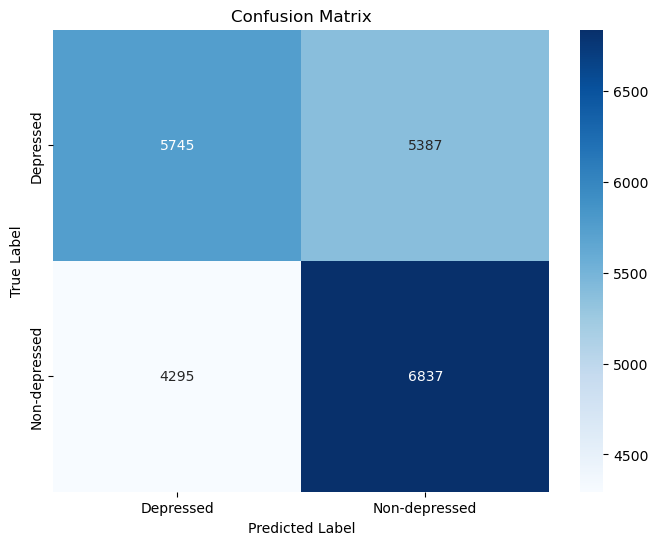

In [47]:
# Calculate the confusion matrix for the combined data
combined_cm = confusion_matrix(lrcombined_true_labels, lrcombined_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(combined_cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Depressed', 'Non-depressed'],
            yticklabels=['Depressed', 'Non-depressed'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



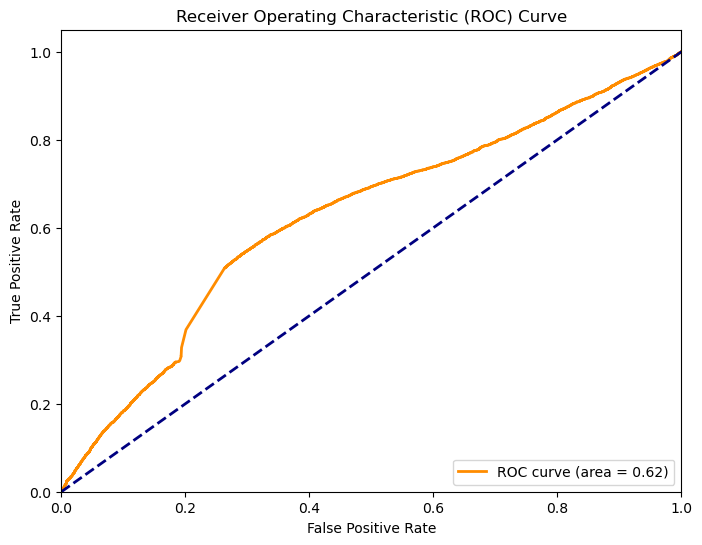

In [48]:
# For the ROC curve:

# After the loop, combine all X_test data
combined_X_test = pd.concat(combined_X_test_list)

# Compute the predicted probabilities using the Random Forest classifier
combined_predicted_probs = lr_best.predict_proba(combined_X_test)[:, 1]

# Compute ROC curve and ROC area for the combined data
fpr, tpr, _ = roc_curve(lrcombined_true_labels, combined_predicted_probs, pos_label='nondepressed')
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

XGBOOST

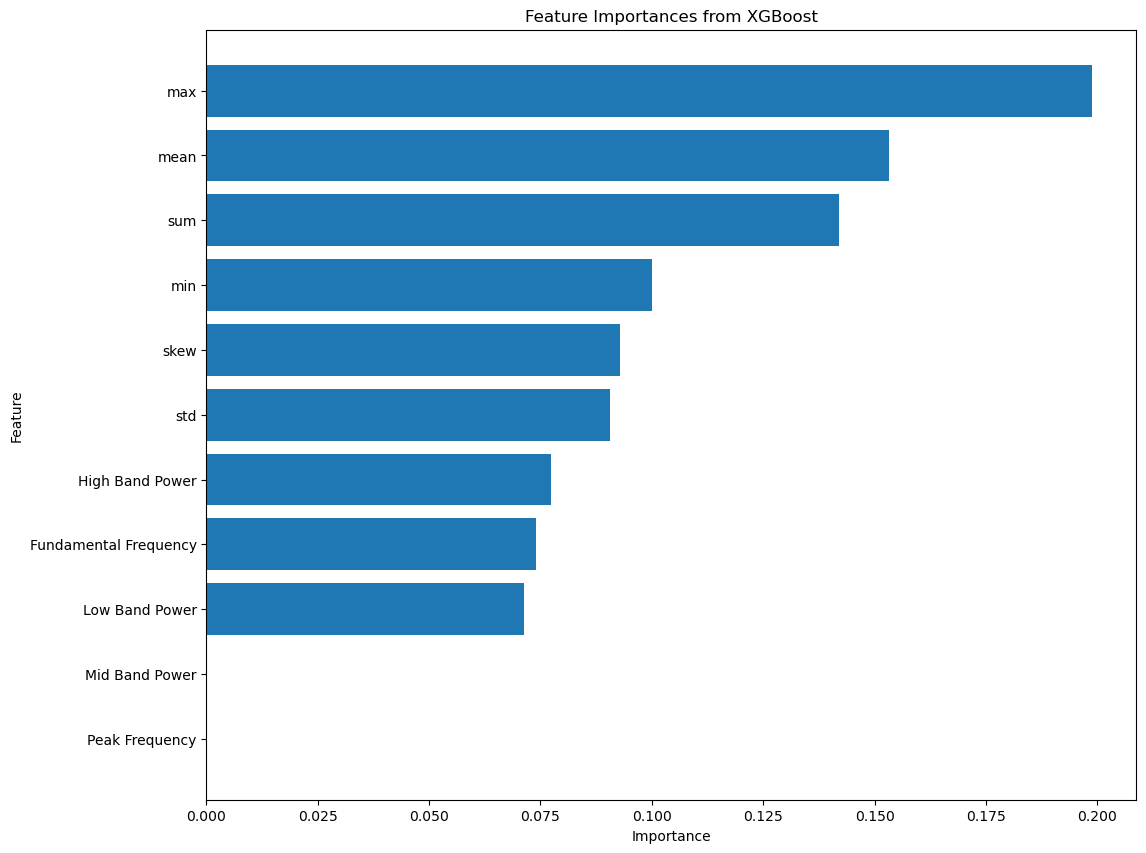

In [15]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
label_encoder = LabelEncoder()
encoded_ty_data = label_encoder.fit_transform(ty_data)

# Initialize and fit the XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(tX_data, encoded_ty_data)

# Extract the feature importances
feature_importances = xgb_model.feature_importances_

# Create a DataFrame to visualize feature importances
importance_df = pd.DataFrame({
    'Feature': tX_data.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from XGBoost')
plt.gca().invert_yaxis()  # To display the feature with the highest importance at the top
plt.show()

In [16]:
#  4. Check the Encoding
print("Classes:", label_encoder.classes_)
print("Encoded labels for classes:", label_encoder.transform(label_encoder.classes_))

Classes: ['depressed' 'nondepressed']
Encoded labels for classes: [0 1]


In [17]:
# Set a threshold
threshold = 0.090  # You can adjust this value based on your needs

# Select features where the importance (magnitude of coefficient) is above the threshold
selected_features = importance_df[importance_df['Importance'].abs() > threshold]['Feature'].tolist()

selected_features


['max', 'mean', 'sum', 'min', 'skew', 'std']

In [18]:
from sklearn.model_selection import RandomizedSearchCV
# Define parameter grid for XGBoost
param_dist = {
    'learning_rate': np.linspace(0.01, 1, 10),
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'gamma': np.linspace(0.01, 1, 10),
    'subsample': np.linspace(0.1, 1, 10),
    'colsample_bytree': np.linspace(0.1, 1, 10)
}



xgb_random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, 
                                       n_iter=100, cv=10, n_jobs=1, verbose=1)
xgb_random_search.fit(tX_data[selected_features], encoded_ty_data)

# Extract best parameters from the RandomizedSearchCV object
best_params = xgb_random_search.best_params_

# Print the best parameters
print(best_params)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0.78, 'colsample_bytree': 0.6}


In [19]:
# Lists to store evaluation metrics
xgbnew_accuracies = []
xgbnew_classification_reports = []
xgbnew_mcc_scores = []
xgbnew_kappa_scores = []
xgbnew_confusion_matrices = []

# Initialize the Random Forest Classifier with the best parameters
xgb_best = xgb.XGBClassifier(**best_params, random_state=42)

# # Use the best estimator from the randomized search
# xgb_best = xgb_random_search.best_estimator_

# Extract unique persons
persons = balanced_trimmed_df['person'].unique()

# Dictionary to store predictions for each person
xgbnew_predictions_dict = {}

In [20]:
# Encode the entire target variable
# label_encoder = LabelEncoder()
# encoded_ty_data = label_encoder.fit_transform(balanced_trimmed_df['status'])


# Create a list to store X_test data for each individual
combined_X_test_list = []


# LOOCV based on persons
for person in persons:
    # Split the data into train and test based on the current person in the loop
    X_train = tX_data[balanced_trimmed_df['person'] != person][selected_features]
    y_train = encoded_ty_data[balanced_trimmed_df['person'] != person]
    X_test = tX_data[balanced_trimmed_df['person'] == person][selected_features]
    y_test = encoded_ty_data[balanced_trimmed_df['person'] == person]
# ...
    
    # Inside your LOOCV loop, after defining X_test, add:
    combined_X_test_list.append(X_test)

    
    # Train the model using the best parameters
    xgb_best.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = xgb_best.predict(X_test)
    
        # Decode the predictions to their original string format
    decoded_predictions = label_encoder.inverse_transform(y_pred)
    
    # Store the decoded predictions in the dictionary
    xgbnew_predictions_dict[person] = decoded_predictions
      
    # Store predictions in the dictionary
    xgbnew_predictions_dict[person] = y_pred
    
    # Calculate evaluation metrics
    xgbnew_accuracies.append(accuracy_score(y_test, y_pred))
    xgbnew_classification_reports.append(classification_report(y_test, y_pred, output_dict=True))
    xgbnew_mcc_scores.append(matthews_corrcoef(y_test, y_pred))
    xgbnew_kappa_scores.append(cohen_kappa_score(y_test, y_pred))
    xgbnew_confusion_matrices.append(confusion_matrix(y_test, y_pred))

# Calculate average metrics
avg_accuracy = np.mean(xgbnew_accuracies)
avg_mcc = np.mean(xgbnew_mcc_scores)
avg_kappa = np.mean(xgbnew_kappa_scores)

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\Ap

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\Ap

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\Ap

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\Ap

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\Ap

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Create lists to store the results
xgbnewpersons_list = []
xgbnewcorrect_percentage_list = []
xgbnewincorrect_percentage_list = []

# Iterate over each person and calculate the percentages
for person, predictions in xgbnew_predictions_dict.items():
    # Get true labels for the person
    true_labels = balanced_trimmed_df[balanced_trimmed_df['person'] == person]['status'].values
    
    # Calculate the number of correct predictions
    xgbcorrect_predictions = np.sum(predictions == true_labels)
    
    # Calculate the percentage of correct and incorrect predictions
    total_predictions = len(predictions)
    correct_percentage = (xgbcorrect_predictions / total_predictions) * 100
    incorrect_percentage = 100 - correct_percentage
    
    # Append to the lists
    xgbnewpersons_list.append(person)
    xgbnewcorrect_percentage_list.append(correct_percentage)
    xgbnewincorrect_percentage_list.append(incorrect_percentage)

# Create a DataFrame from the results
xgbpercentage_df = pd.DataFrame({
    'Person': xgbnewpersons_list,
    'Correct Prediction (%)': xgbnewcorrect_percentage_list,
    'Incorrect Prediction (%)': xgbnewincorrect_percentage_list
})

# Display the DataFrame
xgbpercentage_df

,Person,Correct Prediction (%),Incorrect Prediction (%)
0,condition_1,0.0,100.0
1,condition_10,0.0,100.0
2,condition_11,0.0,100.0
3,condition_12,0.0,100.0
4,condition_13,0.0,100.0
5,condition_14,0.0,100.0
6,condition_15,0.0,100.0
7,condition_16,0.0,100.0
8,condition_17,0.0,100.0
9,condition_18,0.0,100.0


In [30]:
from sklearn.metrics import classification_report

# Lists to store true labels and predictions for each group
xgbcondition_true_labels = []
xgbcondition_predicted_labels = []
xgbcontrol_true_labels = []
xgbcontrol_predicted_labels = []

# Iterate over each person's predictions in the dictionary
for person, predictions in xgbnew_predictions_dict.items():
    # Get true labels for the person
    true_labels = balanced_trimmed_df[balanced_trimmed_df['person'] == person]['status'].values
    
    # Append true labels and predictions to the respective lists based on the person's group
    if person.startswith('condition'):
        xgbcondition_true_labels.extend(true_labels)
        xgbcondition_predicted_labels.extend(predictions)
    else:
        xgbcontrol_true_labels.extend(true_labels)
        xgbcontrol_predicted_labels.extend(predictions)


# Combine true labels and predicted labels from both groups
xgbcombined_true_labels = xgbcondition_true_labels + xgbcontrol_true_labels
xgbcombined_predicted_labels = xgbcondition_predicted_labels + xgbcontrol_predicted_labels

# Generate a single classification report for the combined data
combined_classification_report = classification_report(xgbcombined_true_labels, xgbcombined_predicted_labels, output_dict=True, zero_division=1)

# Convert the classification report to a DataFrame for better visualization
xgbcombined_report_df = pd.DataFrame(combined_classification_report).transpose()

# Display the combined classification report
xgbcombined_report_df


ValueError: Mix of label input types (string and number)

NAIVE BAYES